## Survival Analysis
### Overview of the Notebook
- Dataset Description
- Data cleaning and Feature Selection
- Kaplan-Meier survival estimate
- Cox Proportional Hazards Model - Survival Regression
- Feature selection using Variance Inflation Factor (VIF)
- Further direction

### Why Survival Analysis?
Because Survival Analysis is more than probability

![My normal approach is useless here, too.](Probability.png)
<center>source: <a href="https://xkcd.com/881/">xkcd</a></center>

In [1]:
# !pip install lifelines
import lifelines
import numpy as np
import matplotlib.pyplot as plt # version > 3.0
import pandas as pd

plt.style.use('seaborn')

### Dataset Description
The dataset used in this notebook is from the Northern Alberta Cancer Dataset (NACD). As opposed to the complete NACD datset, this notebook, however, will only consider a sub-set of patients group with stage 4 stomach cancers. This contains a total of 128 patients (100 uncensored) and 53 features.

In [2]:
# NACD Stage 4 Stomach Cancer dataset 
stage4_stomach_cancer = pd.read_csv('All_Data_updated_may2011_Stage4_Stomach.csv')
print("Dataset shape:", stage4_stomach_cancer.shape)
stage4_stomach_cancer.head()

Dataset shape: (128, 53)


,SURVIVAL,CENSORED,GENDER,BOX1_SCORE,BOX2_SCORE,BOX3_SCORE,PERFORMANCE_STATUS,PERFORMANCE_STATUS_0,PERFORMANCE_STATUS_1,PERFORMANCE_STATUS_2,...,AGE,GRANULOCYTES,LDH_SERUM,LYMPHOCYTES,PLATELET,WBC_COUNT,CALCIUM_SERUM,HGB,CREATININE_SERUM,ALBUMIN
0,15.833333,0,0,5,4,8,3,0,0,0,...,29.132786,8.2,423,2.9,449,12.4,2.16,119,51,38
1,10.300000,0,1,1,3,5,1,0,1,0,...,76.334018,6.0,290,1.3,461,8.7,2.34,85,93,36
2,12.566667,0,0,0,1,4,0,1,0,0,...,62.214921,3.8,362,2.4,262,6.9,2.49,121,90,44
3,13.633333,0,0,3,0,0,1,0,1,0,...,65.126626,4.5,140,1.0,306,6.1,2.23,117,51,38
4,55.100000,0,0,3,1,2,0,1,0,0,...,69.989049,6.2,433,0.1,196,6.8,2.29,123,73,38


In [3]:
#print(stage4_stomach_cancer)
stage4_stomach_cancer.keys()

Index(['SURVIVAL', 'CENSORED', 'GENDER', 'BOX1_SCORE', 'BOX2_SCORE',
       'BOX3_SCORE', 'PERFORMANCE_STATUS', 'PERFORMANCE_STATUS_0',
       'PERFORMANCE_STATUS_1', 'PERFORMANCE_STATUS_2', 'PERFORMANCE_STATUS_3',
       'PERFORMANCE_STATUS_4', 'BMI', 'NO_PROBLEM', 'NO_APPETITE', 'NAUSEA',
       'CONSTIPATION', 'SORE_MOUTH', 'TASTE_FUNNY', 'SMELL', 'SWALLOW',
       'FEEL_FULL', 'PAIN', 'OTHER', 'VOMIT', 'DIARRHEA', 'DRY_MOUTH',
       'DENTAL_PROBLEM', 'AGE65', 'WEIGHT_CHANGEPOINT', 'SITE_BRUNCHUS_LUNG',
       'SITE_COLORECTAL', 'SITE_HEAD_AND_NECK', 'SITE_ESOPHAGUS',
       'SITE_PANCREAS', 'SITE_STOMACH', 'SITE_OTHER_DIGESTIVE', 'MISC',
       'STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_NUMERICAL', 'AGE',
       'GRANULOCYTES', 'LDH_SERUM', 'LYMPHOCYTES', 'PLATELET', 'WBC_COUNT',
       'CALCIUM_SERUM', 'HGB', 'CREATININE_SERUM', 'ALBUMIN'],
      dtype='object')

In [4]:
stage4_stomach_cancer.describe()

,SURVIVAL,CENSORED,GENDER,BOX1_SCORE,BOX2_SCORE,BOX3_SCORE,PERFORMANCE_STATUS,PERFORMANCE_STATUS_0,PERFORMANCE_STATUS_1,PERFORMANCE_STATUS_2,...,AGE,GRANULOCYTES,LDH_SERUM,LYMPHOCYTES,PLATELET,WBC_COUNT,CALCIUM_SERUM,HGB,CREATININE_SERUM,ALBUMIN
count,128.000000,128.000000,128.000000,128.000000,128.00000,128.000000,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.00000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,14.079884,0.218750,0.679688,2.109375,1.50000,4.476562,1.507812,0.156250,0.406250,0.234375,...,61.255246,5.525000,672.46875,1.417969,327.867188,7.742188,2.268047,119.218750,85.648438,37.226562
std,14.056316,0.415023,0.468430,1.828189,1.12942,3.873928,1.034797,0.364519,0.493062,0.425272,...,12.772962,3.137781,1071.87508,0.639935,137.987183,3.214304,0.149272,19.541572,29.148166,3.847926
min,0.233333,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,29.132786,0.200000,134.00000,0.100000,78.000000,1.800000,1.850000,60.000000,47.000000,26.000000
25%,4.344672,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,...,52.609172,3.700000,353.00000,0.900000,237.750000,5.700000,2.177500,107.000000,69.000000,35.000000
50%,9.987705,0.000000,1.000000,2.000000,1.00000,4.000000,1.000000,0.000000,0.000000,0.000000,...,62.119781,5.050000,413.00000,1.400000,307.000000,7.200000,2.280000,120.000000,80.000000,38.000000
75%,17.266667,0.000000,1.000000,4.000000,2.00000,7.000000,2.000000,0.000000,1.000000,0.000000,...,71.461157,6.400000,522.00000,1.800000,377.250000,9.100000,2.350000,131.000000,93.000000,40.000000
max,62.766667,1.000000,1.000000,5.000000,4.00000,15.000000,4.000000,1.000000,1.000000,1.000000,...,85.568104,20.700000,7228.00000,2.900000,1000.000000,22.000000,3.270000,167.000000,305.000000,48.000000


### Assess correlation across all 51 features 
(Excluding 'SURVIVAL' and 'DELTA')

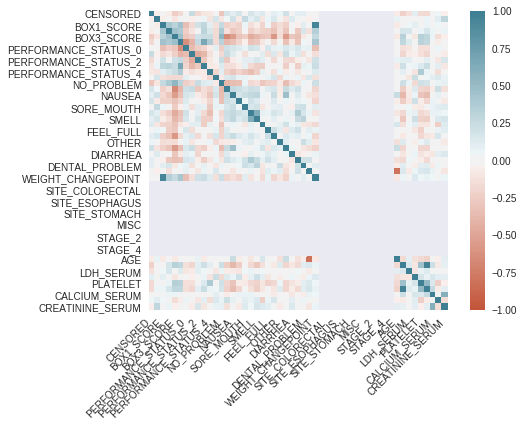

In [5]:
import seaborn as sns

def corr_heatmap(data):
    corr = data.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    
# column from [1:-1] because we don't want 'SURVIVAL' and 'DELTA' to be included in the corr graph
corr_heatmap(stage4_stomach_cancer.iloc[:, 1:-1])

### Data cleaning and Feature Selection
We can see that quite a few featues have zero correlation with each other. In this case, features with zero correlation represent data columns with same values across the subjects. Since all data in this sub-dataset is from stage 4 stomach cancer patients, these columns are redundant. So we remove these before further analysis because they don't provide any additional patient parameter. Features with similar values accross subjects are:

    SITE_BRUNCHUS_LUNG
    SITE_COLORECTAL	
    SITE_HEAD_AND_NECK	
    SITE_ESOPHAGUS	
    SITE_PANCREAS	
    SITE_STOMACH	
    SITE_OTHER_DIGESTIVE	
    MISC	
    STAGE_1	
    STAGE_2	
    STAGE_3	
    STAGE_4	
    STAGE_NUMERICAL

In [6]:
stage4_stomach_cancer = stage4_stomach_cancer.drop(columns = [
                                    'SITE_BRUNCHUS_LUNG', 'SITE_COLORECTAL', 
                                    'SITE_COLORECTAL', 'SITE_HEAD_AND_NECK', 
                                    'SITE_ESOPHAGUS', 'SITE_PANCREAS', 'SITE_STOMACH', 
                                    'SITE_OTHER_DIGESTIVE', 'MISC', 'STAGE_1', 'STAGE_2', 
                                    'STAGE_3', 'STAGE_4', 'STAGE_NUMERICAL'])
print("Dataset shape:", stage4_stomach_cancer.shape)

Dataset shape: (128, 40)


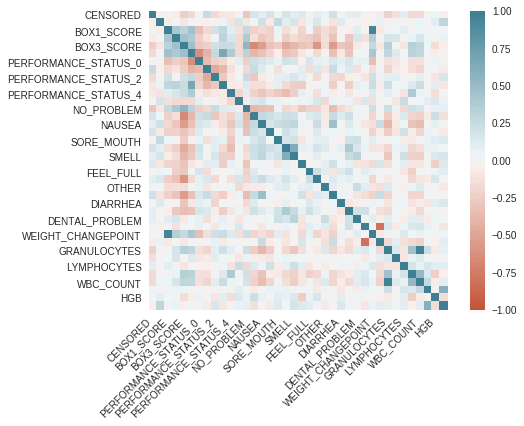

In [7]:
# column from [1:-1] because we don't want 'SURVIVAL' and 'DELTA' to be included in the corr graph
corr_heatmap(stage4_stomach_cancer.iloc[:, 1:-1])

Here, CENSORED = 1 mean that a patient was censored. We need 1 to indicate patient death so we change the column name to 'DELTA'.

In [8]:
stage4_stomach_cancer['DELTA'] = 1 - stage4_stomach_cancer['CENSORED']
stage4_stomach_cancer = stage4_stomach_cancer.drop(['CENSORED'], axis=1)

/home/d/anaconda3/lib/python3.7/site-packages/lifelines/plotting.py:702: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


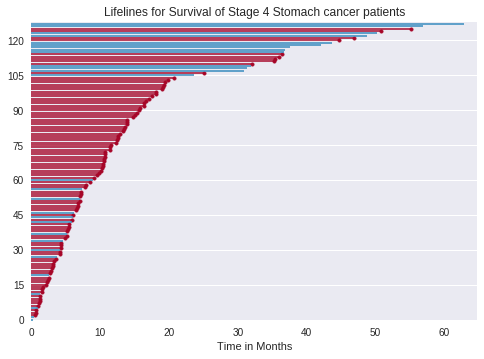

In [9]:
# Plot lifetime distribution
durations = stage4_stomach_cancer.SURVIVAL.values
events = stage4_stomach_cancer.DELTA.values

ax = lifelines.plotting.plot_lifetimes(durations=durations,
                                       event_observed=events)

# extend x axis lim beyond the max of all patient survival
ax.set_xlim(0, stage4_stomach_cancer.SURVIVAL.max() + 2)
ax.grid(axis='x')
ax.set_xlabel("Time in Months")
ax.set_title("Lifelines for Survival of Stage 4 Stomach cancer patients");
plt.plot();

### Kaplan-Meier survival estimate
The Kaplan-Meier method estimates survival probability from observed survival times (**SURVIVAL**). It results in a step function that changes value only at the time of each event (**DELTA**), and confidence intervals can be computed for the survival probabilities.

**Note**: Kaplan-Meier estimate CANNOT account for risk factors and is NOT a regression model. It is a non-parametric model i.e. it doesn't involve parameters (features).

Median Survival: 11.4 months after treatment


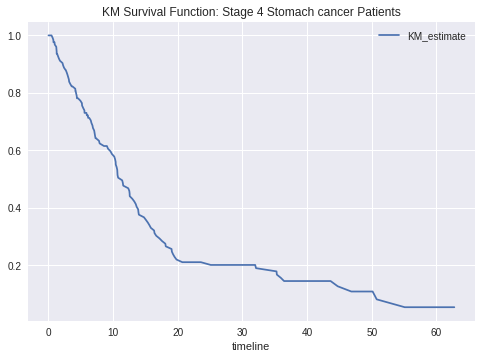

In [10]:
kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations, events)

kmf.survival_function_.plot()
#kmf.plot()
# or kmf.survival_function_.plot.line()
plt.title('KM Survival Function: Stage 4 Stomach cancer Patients');
print(f'Median Survival: {kmf.median_survival_time_} months after treatment')

Median survival time for Males: 10.401639 months
Median survival time for Females: 13.86666667 months


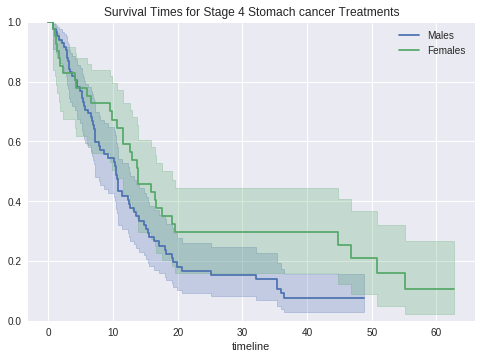

In [11]:
# Compare the effects of a single categorical variable, "GENDER"
ax = plt.subplot(111)

treatment = (stage4_stomach_cancer["GENDER"] == 1)
kmf.fit(durations=durations[treatment], 
        event_observed=events[treatment], 
        label="Males")
kmf.plot(ax=ax)
print(f'Median survival time for Males: {kmf.median_survival_time_} months')

kmf.fit(durations=durations[~treatment], 
        event_observed=events[~treatment], 
        label="Females")
kmf.plot(ax=ax)
print(f'Median survival time for Females: {kmf.median_survival_time_} months')

plt.ylim(0, 1);
plt.title("Survival Times for Stage 4 Stomach cancer Treatments");

### Cox Proportional Hazards Model - Survival Regression
Useful for comparing relative hazards.

It assumes the ratio of death event risks (hazard) of two groups remains about the same over time. This ratio is called the hazards ratio or the relative risk.

In [12]:
stage4_stomach_cancer.shape

(128, 40)

In [13]:
# Using Cox Proportional Hazards model
cph = lifelines.CoxPHFitter()
cph.fit(df=stage4_stomach_cancer, duration_col='SURVIVAL', event_col='DELTA', 
        show_progress=True) #, penalizer=0.1)
cph.print_summary()

Iteration 1: norm_delta = 3.12775, step_size = 0.9000, log_lik = -399.90843, newton_decrement = 72.47672, seconds_since_start = 0.0


/home/d/anaconda3/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:1498: LinAlgWarning: Ill-conditioned matrix (rcond=4.51539e-18): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
/home/d/anaconda3/lib/python3.7/site-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column DENTAL_PROBLEM have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['DELTA'].astype(bool)
>>> print(df.loc[events, 'DENTAL_PROBLEM'].var())
>>> print(df.loc[~events, 'DENTAL_PROBLEM'].var())

A very low variance means that the column DENTAL_PROBLEM completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

The above Cox Proportional Hazards model fails to converge due to matrix inversion problems. Most likely culprit for this is high feature collinearity  <br />

- [What is multicollinearity and how to remove it?](https://medium.com/analytics-vidhya/what-is-multicollinearity-and-how-to-remove-it-413c419de2f)

    The best way to identify the multicollinearity is to calculate the **Variance Inflation Factor (VIF)** corresponding to every independent Variable in the Dataset.


**Variance Inflation Factor** - Variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. VIF value can be interpreted as  <br />

    1 (Non-collinear) 
    1-5 (Medium collinear) 
    >5 (Highly collinear)
The values having VIF value above 5 are removed in this analysis. [Link.](https://towardsdatascience.com/https-towardsdatascience-com-multicollinearity-how-does-it-create-a-problem-72956a49058)
    

### Feature selection using Variance Inflation Factor (VIF)

In [14]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = stage4_stomach_cancer.drop(['SURVIVAL', 'DELTA'], axis=1)
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

vif_df = pd.DataFrame(vif)
drop_columns = np.flatnonzero(vif_df > 5)
# Since the first two columns in stage4_stomach_cancer is 'SURVIVAL', 'DELTA', 
# we can ignore those
drop_columns = drop_columns + 2
print(drop_columns)

[1.7509676760642108, 15.935869826823295, 2.310540773648005, inf, inf, 72.26635251378376, inf, inf, inf, inf, 1.4096393849610112, 2.209493478392231, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 4.131412473433198, 14.939299140898783, 4.4194673036520715, 24.406926931841756, 1.2551143038328816, 2.5020534159886547, 2.739367419957698, 25.659048645559658, 3.7586662344017907, 1.662493325471445, 3.4960208553632137, 2.586629936661767]
[ 3  5  6  7  8  9 10 11 14 15 16 17 18 19 20 21 22 23 24 25 26 27 29 31
 35]


In [15]:
stage4_stomach_cancer.drop(stage4_stomach_cancer.columns[drop_columns], 
                           axis=1, 
                           inplace=True)
stage4_stomach_cancer.shape

(128, 15)

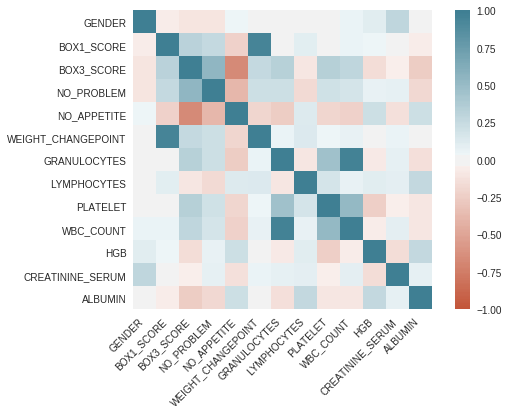

In [16]:
# column from [1:-1] because we don't want 'SURVIVAL' and 'DELTA' to be included in the corr graph
corr_heatmap(stage4_stomach_cancer.iloc[:, 1:-1])

In [17]:
# Using Cox Proportional Hazards model with 15 patient features
cph = lifelines.CoxPHFitter()


stage4_stomach_cancer_train = stage4_stomach_cancer[:64]
stage4_stomach_cancer_test = stage4_stomach_cancer[64:]

cph.fit(df=stage4_stomach_cancer_train, duration_col='SURVIVAL', event_col='DELTA')#, 
        #show_progress=True) #, penalizer=0.1)


# from lifelines.utils import concordance_index
# print('concordance_index:', 
#       concordance_index(stage4_stomach_cancer_train['SURVIVAL'], 
#                         -cph.predict_partial_hazard(stage4_stomach_cancer_train), 
#                         stage4_stomach_cancer_train['DELTA']))

# print('concordance_index:', 
#       concordance_index(stage4_stomach_cancer_test['SURVIVAL'], 
#                         -cph.predict_partial_hazard(stage4_stomach_cancer_test), 
#                         stage4_stomach_cancer_test['DELTA']))

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 64 total observations, 9 right-censored observations>
             duration col = 'SURVIVAL'
                event col = 'DELTA'
      baseline estimation = breslow
   number of observations = 64
number of events observed = 55
   partial log-likelihood = -163.34
         time fit was run = 2021-04-14 19:52:12 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
GENDER               0.42       1.52       0.36            -0.29             1.12                 0.75                 3.06
BOX1_SCORE           0.03       1.03       0.37            -0.70             0.75                 0.50                 2.12
BOX3_SCORE           0.04       1.04       0.08            -0.12             0.20                 0.89                 1.22
NO_PROBLEM           0.50       1.65       0.40            -0.29             1.29                 0.75                 3.64
NO_APPETITE         -0.56       0.57       0.45            -1.44             0.32                 0.24                 1.37
WEIGHT_CHANGEPOINT  -0.00       1.00       0.44            -0.86             0.86                 0.42                 2.35
GRANULOCYTES         0.17       1.18       0.20            -0.23             0.56                 0.80                 1.75
LYMPHOCYTES          0.07       1.07       0.29            -0.50             0.64                 0.61                 1.90
PLATELET             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
WBC_COUNT           -0.10       0.91       0.22            -0.53             0.33                 0.59                 1.40
HGB                 -0.02       0.98       0.01            -0.04            -0.00                 0.96                 1.00
CREATININE_SERUM     0.02       1.02       0.01             0.00             0.04                 1.00                 1.04
ALBUMIN             -0.02       0.98       0.05            -0.12             0.09                 0.88                 1.09

                       z    p   -log2(p)
covariate                               
GENDER              1.16 0.25       2.02
BOX1_SCORE          0.08 0.94       0.09
BOX3_SCORE          0.52 0.60       0.73
NO_PROBLEM          1.25 0.21       2.23
NO_APPETITE        -1.25 0.21       2.25
WEIGHT_CHANGEPOINT -0.00 1.00       0.01
GRANULOCYTES        0.83 0.41       1.30
LYMPHOCYTES         0.24 0.81       0.31
PLATELET            0.73 0.46       1.11
WBC_COUNT          -0.45 0.66       0.61
HGB                -2.24 0.03       5.30
CREATININE_SERUM    2.18 0.03       5.09
ALBUMIN            -0.34 0.74       0.44
---
Concordance = 0.73
Partial AIC = 352.68
log-likelihood ratio test = 34.04 on 13 df
-log2(p) of ll-ratio test = 9.72

### Interpreting the Results
**coef**: usually denoted with $b$, the coefficient

**exp(coef)**: $e^{b}$, equals the estimate of the hazard ratio.

**se(coef)**: standard error of the coefficient (used for calculating z-score and therefore p-value)

**z**: z-score $\frac{b}{se(b)}$

**p**: p-value. derived from z-score. describes statistical significance. more specifically, it is the likelihood that the variable has no effect on the outcome

**log(p)**: natural logarithm of p-value... used to more easily see differences in significance

**lower/upper 0.95**: confidence levels for the coefficients. in this case, we can confidently say that the coefficient for LYMPHOCYTES is somewhere between 0.61 and 1.90.

**Signif. codes**: easily, visually identify significant variables! The more stars, the more solid (simply based on p-value).

**Concordance**: a measure of predictive power for classification problems. Here, looking at the status column, a value from 0 to 1 where values above 0.6 are considered good fits (the higher the better)

**Likelihood ratio (LR) test**: this is a measure of how likely it is that the coefficients are not zero, and can compare the goodness of fit of a model versus an alternative null model. Is often actually calculated as a logarithm, resulting in the log-likelihood ratio statistic and allowing the distribution of the test statistic to be approximated with Wilks' theorem.

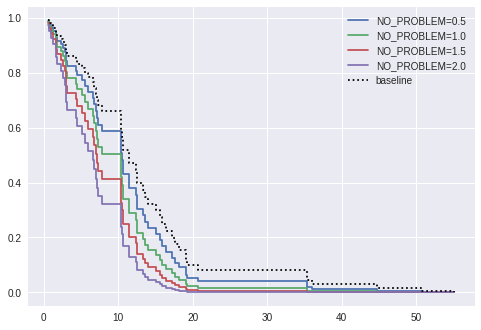

In [18]:
# investigate continuous feature, must bin with 'values' argument
cph.plot_partial_effects_on_outcome(covariates='NO_PROBLEM', values=np.arange(0.5,2.5,.5));

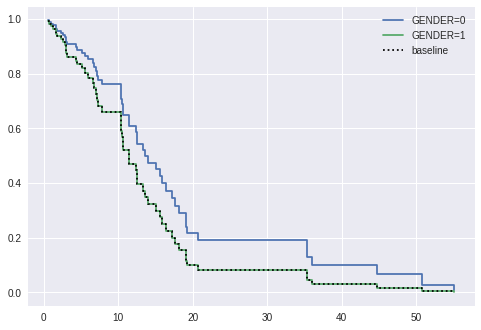

In [19]:
# investigate continuous feature, must bin with 'values' argument
cph.plot_partial_effects_on_outcome(covariates='GENDER', values=[0,1]);

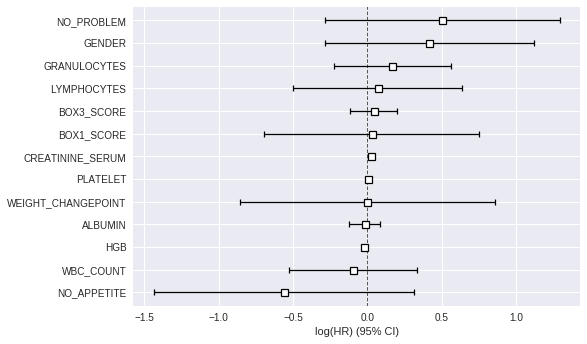

In [20]:
# We can see that most of the variable are not very useful by plotting the coefficients
cph.plot();

In [21]:
cph.compute_residuals(stage4_stomach_cancer_train, kind='score')

covariate,GENDER,BOX1_SCORE,BOX3_SCORE,NO_PROBLEM,NO_APPETITE,WEIGHT_CHANGEPOINT,GRANULOCYTES,LYMPHOCYTES,PLATELET,WBC_COUNT,HGB,CREATININE_SERUM,ALBUMIN
24,2.220446e-16,-1.000000e+00,-5.000000e+00,8.284773e-30,-1.000000e+00,-2.000000e+00,-6.100000e+00,-1.000000e+00,-5.460000e+02,-7.300000e+00,2.200000e+01,1.600000e+01,3.000000e+00
38,2.220446e-16,2.000000e+00,1.000000e+00,8.284773e-30,-1.000000e+00,1.000000e+00,1.000000e+00,-6.000000e-01,-3.800000e+02,7.000000e-01,2.100000e+01,3.200000e+01,4.000000e+00
63,-6.245297e-59,-8.437895e-43,8.437895e-43,-2.330202e-72,-8.960538e-55,-5.625263e-43,1.603200e-42,2.250105e-43,1.594762e-40,1.912589e-42,-4.500211e-42,-2.531368e-42,-3.656421e-42
47,-1.000000e+00,1.000000e+00,-2.000000e+00,8.284773e-30,3.185820e-12,-3.184120e-12,-3.200000e+00,1.000000e-01,-5.090000e+02,-2.700000e+00,2.300000e+01,1.100000e+01,7.000000e+00
62,-1.000000e+00,-2.000000e+00,-1.000000e+00,8.284773e-30,-1.000000e+00,-2.000000e+00,-5.200000e+00,-1.000000e+00,-5.880000e+02,-6.800000e+00,-2.000000e+00,4.500000e+01,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,4.899477e-01,-9.744134e-01,2.940700e-01,6.586463e-03,-3.877946e-08,-1.466280e+00,2.117762e-01,-5.571418e-01,4.909121e+00,-2.203912e-01,1.388282e+00,7.034767e-01,4.150950e+00
51,-2.304964e-07,9.674970e-07,-2.395433e-07,3.042087e-10,-1.791105e-15,9.447792e-07,9.969709e-07,2.527054e-07,1.161739e-05,1.407324e-06,-5.251516e-06,7.918681e-07,-1.073908e-06
20,3.278730e-19,1.401800e-17,-3.470729e-18,4.407660e-21,-2.595121e-26,1.368885e-17,1.334479e-17,4.394937e-18,8.174747e-16,2.002388e-17,8.161448e-17,1.178314e-16,1.744790e-17
37,1.246647e-12,-1.335086e-03,4.450287e-04,-4.450287e-04,-9.867235e-20,-8.900574e-04,-7.120460e-04,4.450287e-04,2.981693e-02,-1.335086e-04,5.785373e-03,-1.780115e-03,4.450287e-04


In [22]:
stage4_stomach_cancer.shape

(128, 15)

In [23]:
cph.predict_cumulative_hazard(stage4_stomach_cancer_test)#[:5])

,64,65,66,67,68,69,70,71,72,73,...,118,119,120,121,122,123,124,125,126,127
0.633333,0.026802,0.011475,0.006081,0.007664,0.008574,0.008829,20.460889,0.003306,0.008225,0.012263,...,0.005664,0.010252,0.007893,0.019929,0.002582,0.078774,0.017047,0.019872,0.009568,0.004635
0.754098,0.053903,0.023077,0.012229,0.015414,0.017243,0.017757,41.149404,0.006649,0.016542,0.024663,...,0.011391,0.020619,0.015875,0.040079,0.005192,0.158424,0.034284,0.039966,0.019243,0.009322
0.933333,0.053903,0.023077,0.012229,0.015414,0.017243,0.017757,41.149404,0.006649,0.016542,0.024663,...,0.011391,0.020619,0.015875,0.040079,0.005192,0.158424,0.034284,0.039966,0.019243,0.009322
0.967213,0.082390,0.035273,0.018693,0.023560,0.026357,0.027142,62.896432,0.010162,0.025284,0.037698,...,0.017410,0.031516,0.024264,0.061260,0.007936,0.242150,0.052402,0.061087,0.029413,0.014248
1.204918,0.111022,0.047531,0.025188,0.031748,0.035516,0.036573,84.753410,0.013694,0.034070,0.050798,...,0.023461,0.042468,0.032696,0.082549,0.010694,0.326299,0.070613,0.082315,0.039634,0.019199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44.733333,12.342431,5.284096,2.800231,3.529461,3.948320,4.065916,9422.160455,1.522350,3.787626,5.647278,...,2.608161,4.721193,3.634911,9.177077,1.188885,36.275136,7.850115,9.151112,4.406183,2.134388
48.766667,12.342431,5.284096,2.800231,3.529461,3.948320,4.065916,9422.160455,1.522350,3.787626,5.647278,...,2.608161,4.721193,3.634911,9.177077,1.188885,36.275136,7.850115,9.151112,4.406183,2.134388
50.133333,12.342431,5.284096,2.800231,3.529461,3.948320,4.065916,9422.160455,1.522350,3.787626,5.647278,...,2.608161,4.721193,3.634911,9.177077,1.188885,36.275136,7.850115,9.151112,4.406183,2.134388
50.766667,16.512554,7.069428,3.746342,4.721956,5.282334,5.439662,12605.615457,2.036705,5.067347,7.555318,...,3.489377,6.316338,4.863034,12.277726,1.590572,48.531376,10.502424,12.242989,5.894895,2.855532


64     5.50
65     9.97
66    16.20
67    13.55
68    12.42
69    12.14
70     0.00
71    24.87
72    12.83
73     9.50
dtype: float64


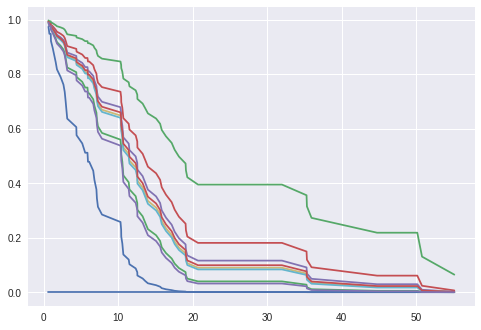

In [24]:
# Survival curves for 10 patients in the test dataset
surv_func = cph.predict_survival_function(stage4_stomach_cancer_test[:10])

exp_lifetime = cph.predict_expectation(stage4_stomach_cancer_test[:10])

plt.plot(surv_func)

print(round(exp_lifetime,2))

In [25]:
stage4_stomach_cancer_test[:10]

,SURVIVAL,GENDER,BOX1_SCORE,BOX3_SCORE,NO_PROBLEM,NO_APPETITE,WEIGHT_CHANGEPOINT,GRANULOCYTES,LYMPHOCYTES,PLATELET,WBC_COUNT,HGB,CREATININE_SERUM,ALBUMIN,DELTA
64,9.200000,1,2,10,0,0,1,5.9,1.6,302,5.3,98,75,32,1
65,2.400000,1,5,6,0,0,4,6.4,1.7,248,8.9,156,108,30,1
66,6.540984,0,0,2,0,0,0,8.7,0.4,360,10.0,106,53,33,1
67,6.300000,1,3,1,0,0,2,4.1,2.2,364,7.1,136,88,35,0
68,32.100000,1,4,12,0,-1,4,2.0,0.9,217,3.2,132,57,39,1
69,6.877049,1,0,8,0,0,0,5.0,1.4,282,8.0,122,79,38,1
70,2.166667,1,4,10,0,-1,4,12.4,2.2,348,15.5,60,305,35,1
71,13.500000,1,1,0,-1,0,0,3.9,1.2,169,5.7,139,91,36,1
72,36.433333,1,0,1,-1,0,0,6.8,1.5,439,9.6,106,79,36,1
73,16.333333,1,0,1,-1,0,0,4.1,1.0,308,6.4,109,117,38,1


In [26]:
# 5-fold Cross Validation for CoxPH Model
from lifelines.utils import k_fold_cross_validation

print("CoxPH Mean Concordance 5-fold CV:", 
      np.mean(k_fold_cross_validation(cph, stage4_stomach_cancer, 
                                      duration_col='SURVIVAL', event_col='DELTA', k=5,
                                      scoring_method="concordance_index")))

CoxPH Mean Concordance 5-fold CV: 0.667054988736311


### Further direction
- Using other scoring metrics to assess the reliability of the models
- Individualized survival distribution - Multi-task Logistic Regression Models  
- Implement the D-Calibration metrics